<a href="https://colab.research.google.com/github/PranavDixit2/Dementia/blob/main/Alz_V8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install tensorflow opencv-python matplotlib seaborn scikit-learn kagglehub --quiet

# Step 2: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
import kagglehub
import shutil
import random
import cv2
import numpy as np
from PIL import Image


In [9]:
print("Downloading dataset...")
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset-v2")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/augmented-alzheimer-mri-dataset-v2


In [10]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/"
train_data_path = os.path.join(dataset_path, "train")
val_data_path = os.path.join(dataset_path, "val")
TARGET_CLASSES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
# Function to explore the dataset
def explore_dataset(dataset_path):
    class_counts = {}
    total_images = 0

    # Check the structure
    for root, dirs, files in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
            total_images += num_files

    print("Dataset Overview:")
    print(f"Total Classes: {len(class_counts)}")
    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")

    return class_counts

print("Exploring the dataset...")
class_counts = explore_dataset(dataset_path)


Exploring the dataset...
Dataset Overview:
Total Classes: 6
Total Images: 40392
Class Distribution:
  val: 4
  train: 4
  ModerateDemented: 6464
  NonDemented: 9600
  VeryMildDemented: 8960
  MildDemented: 8960


In [11]:
# Set seed for reproducibility
random.seed(42)

# Source and destination directories
src_base_dir = os.path.join(dataset_path, "train")
dest_base_dir = "/content/sample_data/train"

# Ensure destination directory exists
os.makedirs(dest_base_dir, exist_ok=True)

samples_per_class = 2500
TARGET_CLASSES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

for class_name in TARGET_CLASSES:
    src_class_dir = os.path.join(src_base_dir, class_name)
    dest_class_dir = os.path.join(dest_base_dir, class_name)
    os.makedirs(dest_class_dir, exist_ok=True)

    all_images = os.listdir(src_class_dir)
    selected_images = random.sample(all_images, samples_per_class)

    print(f"Copying {samples_per_class} images from '{class_name}'...")
    for img_file in selected_images:
        src_path = os.path.join(src_class_dir, img_file)
        dest_path = os.path.join(dest_class_dir, img_file)
        shutil.copy2(src_path, dest_path)

print("Sampling complete. Images are saved to:", dest_base_dir)

Copying 2500 images from 'MildDemented'...
Copying 2500 images from 'ModerateDemented'...
Copying 2500 images from 'NonDemented'...
Copying 2500 images from 'VeryMildDemented'...
Sampling complete. Images are saved to: /content/sample_data/train


In [12]:
sample_dataset = "/content/sample_data/train"
explore_dataset(sample_dataset)

Dataset Overview:
Total Classes: 4
Total Images: 10000
Class Distribution:
  VeryMildDemented: 2500
  MildDemented: 2500
  NonDemented: 2500
  ModerateDemented: 2500


{'VeryMildDemented': 2500,
 'MildDemented': 2500,
 'NonDemented': 2500,
 'ModerateDemented': 2500}

In [13]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

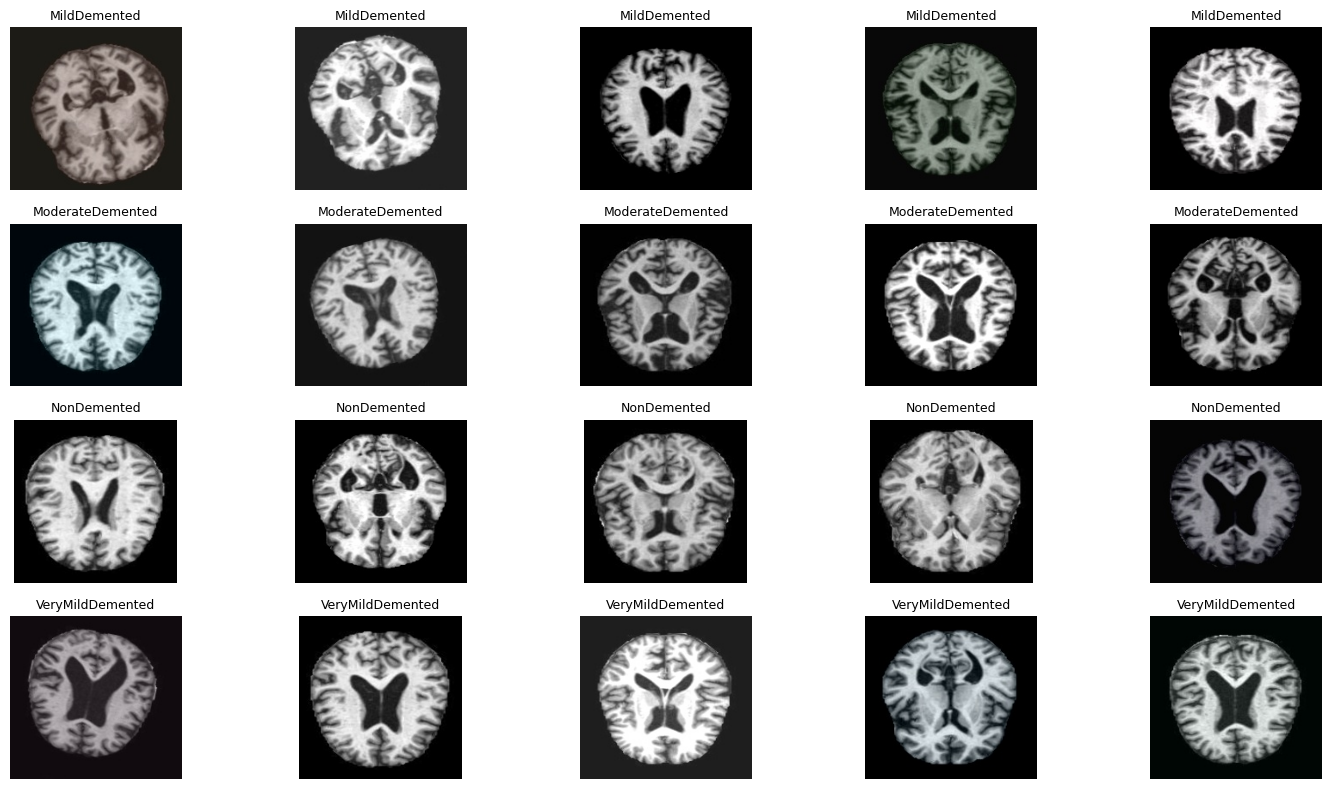

In [14]:
def visualize_samples(base_dir, target_classes, samples_per_class=5):
    plt.figure(figsize=(15, 8))
    for idx, class_name in enumerate(target_classes):
        class_dir = os.path.join(base_dir, class_name)
        images = os.listdir(class_dir)[:samples_per_class]
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            plt.subplot(len(target_classes), samples_per_class, idx * samples_per_class + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{class_name}", fontsize=9)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(sample_dataset, TARGET_CLASSES)


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    sample_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    sample_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)


Found 8000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [16]:
def build_resnet50_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_resnet50_model()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("resnet50_best.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.2793 - loss: 1.4068

125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2793 - loss: 1.4068 - val_accuracy: 0.3160 - val_loss: 1.3668 - learning_rate: 1.0000e-04
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.2837 - loss: 1.3942

125/125 ━━━━━━━━━━━━━━━━━━━━ 123s 985ms/step - accuracy: 0.2837 - loss: 1.3942 - val_accuracy: 0.3335 - val_loss: 1.3642 - learning_rate: 1.0000e-04
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.2827 - loss: 1.3885

125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 975ms/step - accuracy: 0.2827 - loss: 1.3884 - val_accuracy: 0.3350 - val_loss: 1.3617 - learning_rate: 1.0000e-04
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 978ms/step - accuracy: 0.2767 - loss: 1.3874 - val_accuracy: 0.3210 - val_loss: 1.3628 - learning_rate: 1.0000e-04
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2865 - loss: 1.3784 - val_accuracy: 0.3390 - val_loss: 1.3629 - learning_rate: 1.0000e-04


In [19]:
# Define path to original 'val' data from dataset
test_data_path = os.path.join(dataset_path, "val")

# Prepare test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Keep order for true label extraction
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

Found 6400 images belonging to 4 classes.
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 318ms/step - accuracy: 0.1735 - loss: 1.3925
Test Accuracy: 0.2516


100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step


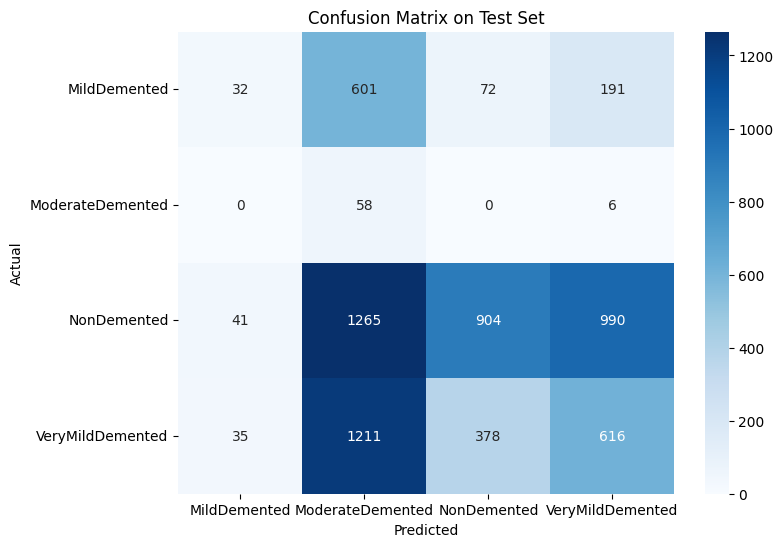

📊 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.30      0.04      0.06       896
ModerateDemented       0.02      0.91      0.04        64
     NonDemented       0.67      0.28      0.40      3200
VeryMildDemented       0.34      0.28      0.30      2240

        accuracy                           0.25      6400
       macro avg       0.33      0.37      0.20      6400
    weighted avg       0.50      0.25      0.31      6400



In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [21]:
from sklearn.metrics import roc_auc_score

# Get ground truth labels and predicted probabilities
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=1)

# Convert ground truth to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_true_onehot = to_categorical(y_true, num_classes=len(TARGET_CLASSES))

# Compute multi-class ROC AUC score
auc = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr')
print(f" Multi-Class AUC-ROC Score: {auc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 862ms/step
 Multi-Class AUC-ROC Score: 0.5051


In [22]:
# Unfreeze the base ResNet50 model correctly
base_model = model.layers[0]  # ResNet50 is the first layer in your composite model
base_model.trainable = True

In [23]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on the sampled training set
train_labels = train_generator.classes
class_weights_array = compute_class_weight(class_weight='balanced',
                                           classes=np.unique(train_labels),
                                           y=train_labels)
class_weights = dict(enumerate(class_weights_array))
print("Computed class weights:", class_weights)


Computed class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


In [24]:
# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("/content/resnet50_finetuned.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=fine_tune_callbacks
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.2905 - loss: 1.3810

125/125 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2905 - loss: 1.3810 - val_accuracy: 0.3415 - val_loss: 1.3615 - learning_rate: 1.0000e-05
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.2932 - loss: 1.3746

125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 964ms/step - accuracy: 0.2932 - loss: 1.3746 - val_accuracy: 0.3395 - val_loss: 1.3607 - learning_rate: 1.0000e-05
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 977ms/step - accuracy: 0.2906 - loss: 1.3770 - val_accuracy: 0.3435 - val_loss: 1.3618 - learning_rate: 1.0000e-05
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 973ms/step - accuracy: 0.2741 - loss: 1.3894 - val_accuracy: 0.3495 - val_loss: 1.3617 - learning_rate: 1.0000e-05
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 966ms/step - accuracy: 0.2879 - loss: 1.3790 - val_accuracy: 0.3440 - val_loss: 1.3622 - learning_rate: 2.0000e-06


In [27]:
# Evaluate accuracy
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Fine-tuned Test Accuracy: {test_acc:.4f}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.3006 - loss: 1.3827
Fine-tuned Test Accuracy: 0.2511


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step


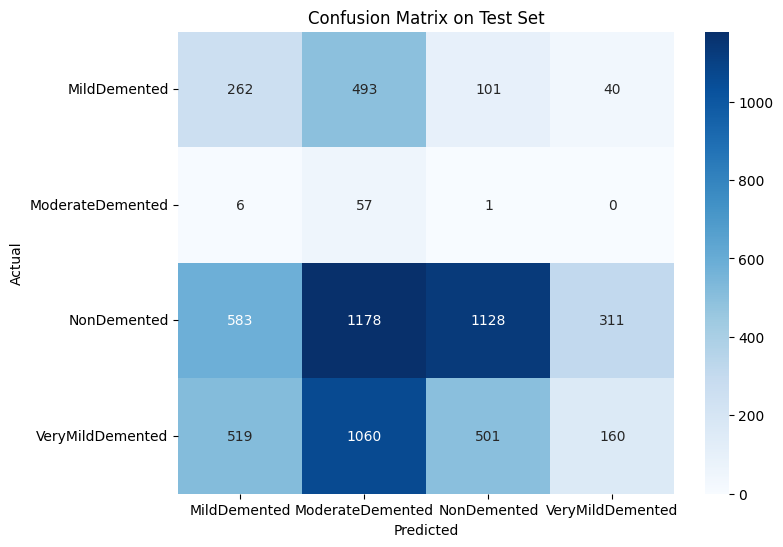

📊 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.19      0.29      0.23       896
ModerateDemented       0.02      0.89      0.04        64
     NonDemented       0.65      0.35      0.46      3200
VeryMildDemented       0.31      0.07      0.12      2240

        accuracy                           0.25      6400
       macro avg       0.29      0.40      0.21      6400
    weighted avg       0.46      0.25      0.30      6400



In [28]:
# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [29]:

def preprocess_mri_image(image_path, method="clahe"):
    """
    Applies preprocessing to an MRI image.

    Parameters:
        image_path (str): Path to the image.
        method (str): One of ['hist_eq', 'clahe', 'zscore'].

    Returns:
        preprocessed image as a NumPy array (224x224).
    """
    # Load in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))

    if method == "hist_eq":
        # Histogram Equalization
        img = cv2.equalizeHist(img)

    elif method == "clahe":
        # CLAHE (Adaptive Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

    elif method == "zscore":
        # Z-score normalization
        img = (img - np.mean(img)) / (np.std(img) + 1e-8)
        img = np.clip(img, -3, 3)  # optional for robustness
        img = ((img + 3) / 6) * 255  # scale back to 0-255
        img = img.astype(np.uint8)

    else:
        raise ValueError("Invalid method. Choose from 'hist_eq', 'clahe', 'zscore'.")

    # Convert to RGB for compatibility with ResNet/EfficientNet
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb


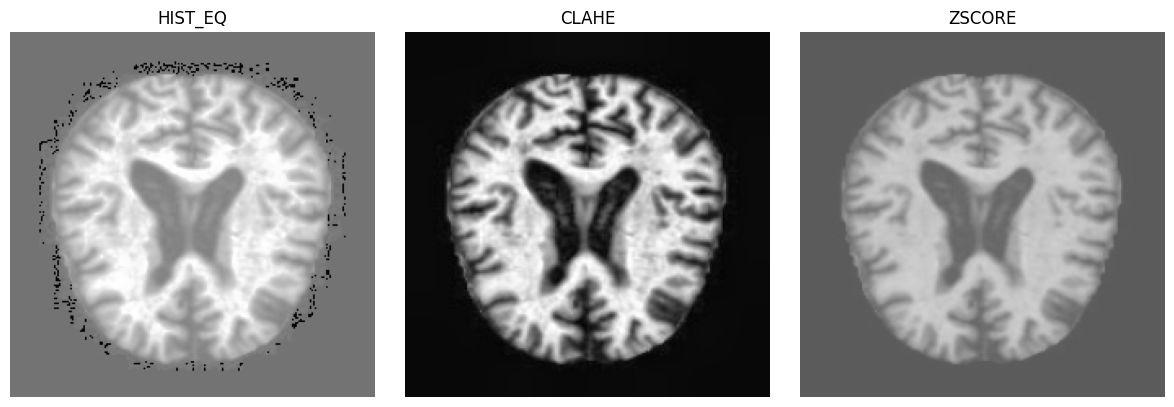

In [30]:
sample_path = os.path.join(sample_dataset, "ModerateDemented", os.listdir(os.path.join(sample_dataset, "ModerateDemented"))[0])

methods = ["hist_eq", "clahe", "zscore"]
plt.figure(figsize=(12, 4))
for i, method in enumerate(methods):
    pre_img = preprocess_mri_image(sample_path, method=method)
    plt.subplot(1, 3, i+1)
    plt.imshow(pre_img, cmap='gray')
    plt.title(method.upper())
    plt.axis('off')
plt.tight_layout()
plt.show()


In [31]:
def preprocess_and_save_images(input_dir, output_dir, method="clahe"):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in os.listdir(input_dir):
        src_class_path = os.path.join(input_dir, class_name)
        dst_class_path = os.path.join(output_dir, class_name)
        os.makedirs(dst_class_path, exist_ok=True)

        for filename in os.listdir(src_class_path):
            img_path = os.path.join(src_class_path, filename)
            img = preprocess_mri_image(img_path, method=method)
            save_path = os.path.join(dst_class_path, filename)
            cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    print(f"✅ Preprocessed images saved to: {output_dir}")
preprocessed_dir = "/content/preprocessed_mri/clahe"
preprocess_and_save_images("/content/sample_data/train", preprocessed_dir, method="clahe")


✅ Preprocessed images saved to: /content/preprocessed_mri/clahe


In [32]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = tf.keras.models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class
    ])

    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_custom_cnn()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    preprocessed_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    preprocessed_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 8000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [34]:
custom_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("cnn_clahe_best.keras", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=custom_callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.3827 - loss: 1.2970 - val_accuracy: 0.5820 - val_loss: 0.9350 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.6121 - loss: 0.8867 - val_accuracy: 0.6965 - val_loss: 0.7187 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.7021 - loss: 0.7084 - val_accuracy: 0.7150 - val_loss: 0.6526 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.7669 - loss: 0.5508 - val_accuracy: 0.7705 - val_loss: 0.5538 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.8130 - loss: 0.4704 - val_accuracy: 0.7670 - val_loss: 0.5265 - learning_rate: 1.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8533 - loss: 0.3662 - val_accuracy: 0.8060 - val_loss: 0.4747 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/ste

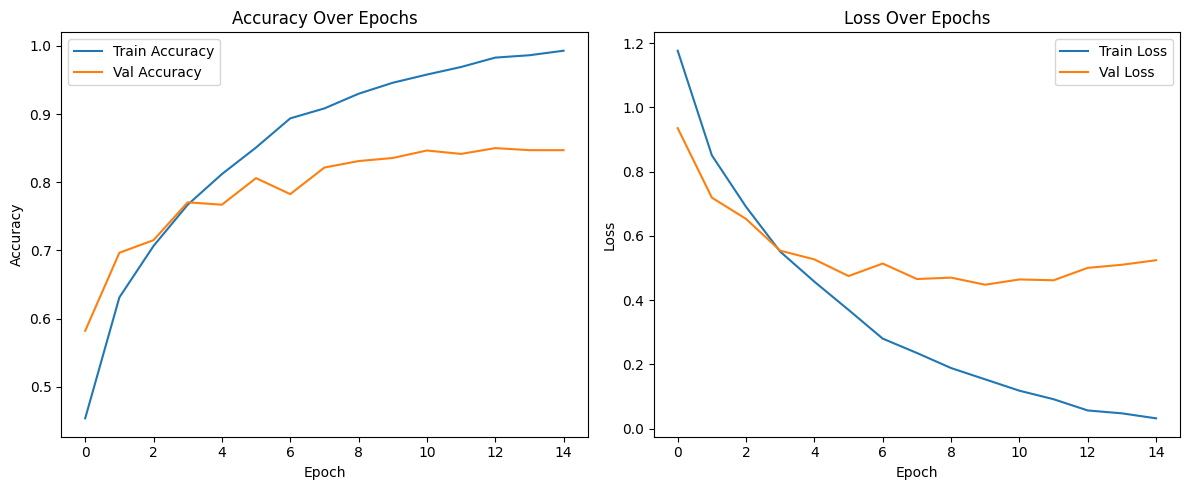

In [35]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [36]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, "val"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


Found 6400 images belonging to 4 classes.
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.8919 - loss: 0.2815
Test Accuracy: 0.7830


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


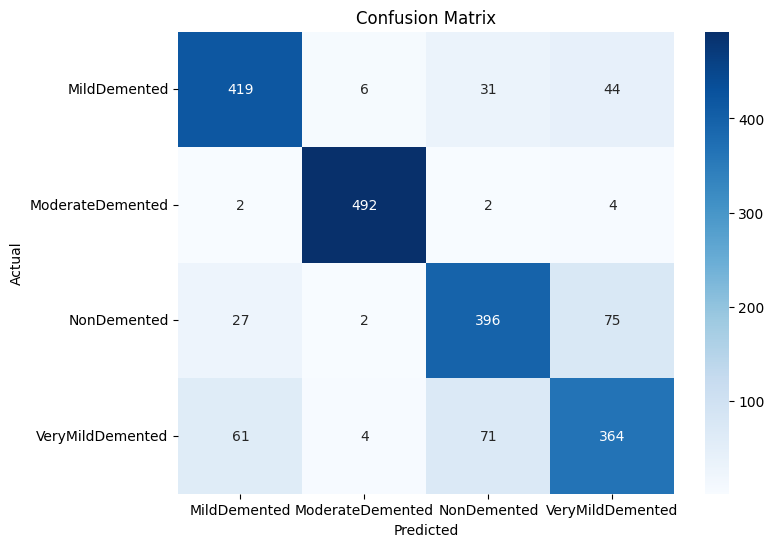

📊 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.82      0.84      0.83       500
ModerateDemented       0.98      0.98      0.98       500
     NonDemented       0.79      0.79      0.79       500
VeryMildDemented       0.75      0.73      0.74       500

        accuracy                           0.84      2000
       macro avg       0.83      0.84      0.84      2000
    weighted avg       0.83      0.84      0.84      2000



In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [43]:
from sklearn.metrics import roc_auc_score

# Get ground truth labels and predicted probabilities
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=1)

# Convert ground truth to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_true_onehot = to_categorical(y_true, num_classes=len(TARGET_CLASSES))

# Compute multi-class ROC AUC score
auc = roc_auc_score(y_true_onehot, y_pred_probs, multi_class='ovr')
print(f" Multi-Class AUC-ROC Score: {auc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step
 Multi-Class AUC-ROC Score: 0.9610


In [38]:
# Print all layer names for reference
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - {layer.__class__.__name__}")


0: conv2d - Conv2D
1: max_pooling2d - MaxPooling2D
2: conv2d_1 - Conv2D
3: max_pooling2d_1 - MaxPooling2D
4: conv2d_2 - Conv2D
5: max_pooling2d_2 - MaxPooling2D
6: flatten - Flatten
7: dense_2 - Dense
8: dropout_2 - Dropout
9: dense_3 - Dense
